In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torch.nn as nn
from torchvision.transforms import v2
import multiprocessing
import sklearn.metrics

In [49]:
# device settings

num_workers = multiprocessing.cpu_count() // 2

print(torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

AMD Radeon RX 7800 XT
Using cuda device


In [ ]:
# define datasets and loaders

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = CIFAR10("./../data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=num_workers, drop_last=True)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [51]:
class BaseNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model_base = BaseNN(num_classes=10).to(device)
model_base.load_state_dict(torch.load("../models/base.pt"))
model_base.eval()

BaseNN(
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [52]:
class StudentSelfTaughtNN(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentSelfTaughtNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model_student_self_taught = StudentSelfTaughtNN(num_classes=10).to(device)
model_student_self_taught.load_state_dict(torch.load("../models/student_self_taught.pt"))
model_student_self_taught.eval()

StudentSelfTaughtNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [53]:
class StudentNN(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.regressor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        intermediate_teaching_layer_output = self.regressor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, intermediate_teaching_layer_output

model_student = StudentNN(num_classes=10).to(device)
model_student.load_state_dict(torch.load("../models/student.pt"))
model_student.eval()

StudentNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [54]:
def test(model, is_student=False):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            if not is_student:
                outputs = model(inputs)
            else:
                outputs, _ = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [63]:
base_accuracy = test(model_base)
student_accuracy = test(model_student, is_student=True)
student_accuracy_self_taught = test(model_student_self_taught)

Test Accuracy: 72.87%
Test Accuracy: 69.25%
Test Accuracy: 68.65%


In [64]:
print(f'distillation accuracy change: {(student_accuracy - base_accuracy):.2f}%')


distillation accuracy change: -3.62%


In [60]:
print(f'model_base size: {os.path.getsize('../models/base.pt')/(1024*1024):.2f} MB')
print(f'model_student size: {os.path.getsize('../models/student.pt')/(1024*1024):.2f} MB')
print(f'model_student_self_taught size: {os.path.getsize('../models/student_self_taught.pt')/(1024*1024):.2f} MB')

model_base size: 4.53 MB
model_student size: 1.04 MB
model_student_self_taught size: 1.03 MB


In [56]:
def plot_confusion_matrix(model, is_student=False):
    confusion_matrix = np.zeros((10, 10), dtype=int)

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            if not is_student:
                outputs = model(inputs)
            else:
                outputs, _ = model(inputs)
        
        outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
        confusion_matrix = np.add(confusion_matrix, sklearn.metrics.confusion_matrix(labels.cpu(), outputs))

    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

    plt.show()

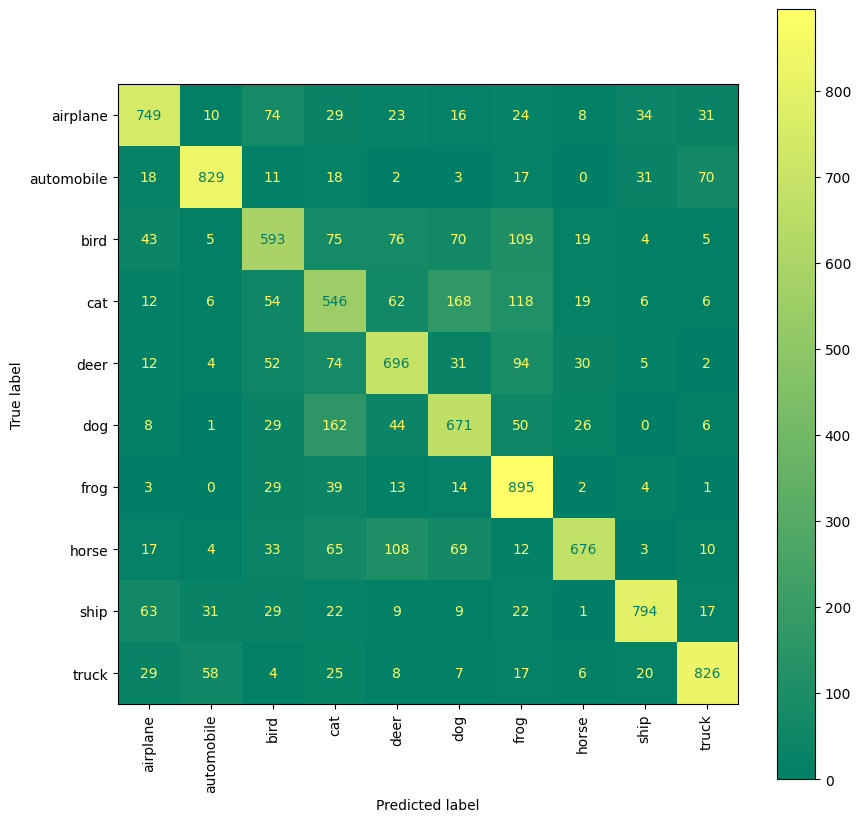

In [57]:
plot_confusion_matrix(model_base)

In [65]:
# plot_confusion_matrix(model_student, is_student=True)

In [66]:
# plot_confusion_matrix(model_student_self_taught)